In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
from colicoords.cnn.unet import get_unet_256
from colicoords.cnn.preprocess import norm_stack, resize_stack
import numpy as np
import mahotas as mh
import tifffile

In this example we will apply the previously trained convolutional neural network to new binary images to segment them. The first step is to load the data, apply preprocessing and to generate a new empty model. This model must be the exact same shape as the one that was used to train the network.

In [2]:
brightfield = tifffile.imread(r'PATH TO BRIGHTFIELD')
brightfield_norm = norm_stack(brightfield)
brightfield_resized = resize_stack(brightfield_norm, 0.5)

In [6]:
model = get_unet_256(input_shape=(256, 256, 1))

In [7]:
model.load_weights('PATH TO MODEL WEIGHTS.h5')

After loading the data and the model we are ready to segment new images. Because the input shape of the model is `(256, 256, 1)` the model expects a stack of images in the shape `(z, 256, 256, 1)`. The input brightfield stack shape is currently `(z, 256, 256)`, therefore `np.expand_dims` is used to create the required shape. 

In [10]:
prediction = model.predict(np.expand_dims(brightfield_resized, -1))

Conversely, the output shape is `(z, 256, 256, 1)` so the last dimension is removed by `squeeze()`, and the image is resized back to `(z, 512, 512)`. 

In [13]:
predict_resized = resize_stack(prediction.squeeze(), 2)
predict_resized.shape

(474, 512, 512)

<IPython.core.display.Javascript object>


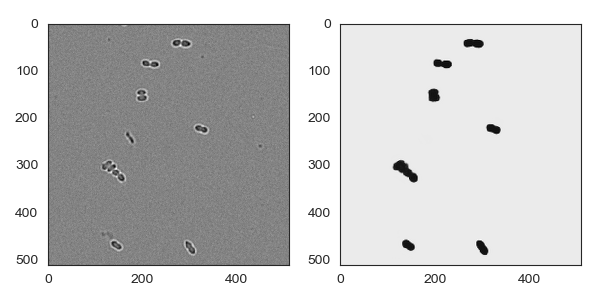

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(brightfield[30], cmap='gray')
axes[1].imshow(predict_resized[30], cmap='gray_r')
plt.tight_layout()

As can be seen the segmentation is quite accurate. The output image has values between 0 and 1, where if the output is 1 the neural network is quite confident that that pixel belongs to a cell. Lower values can occur on cells which might be out of focus (unless the network was trained on sufficient out of focus cells), or cells that lie on the border of the image (if the network was trained not to segment cells on the border). 

The final binary can be obtained by simply thresholding the binary images. In the following cell this is done with a value of 0.5. The following lines clean up the binary images, any holes in the segments are closed and small speckles are removed (`min_size=150`). The final out put is a labeled binary image.

In [20]:
labeled_binary = np.empty_like(predict_resized, dtype=int)
for i, img in enumerate(predict_resized):
    binary = img > 0.5
    closed = mh.close_holes(binary)
    labeled, n = mh.labeled.label(closed)
    labeled, n = mh.labeled.filter_labeled(labeled, remove_bordering=True, min_size=250)
    labeled_binary[i] = labeled

<IPython.core.display.Javascript object>


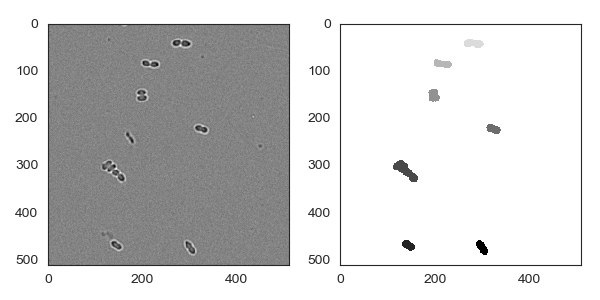

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(brightfield[30], cmap='gray')
axes[1].imshow(labeled_binary[30], cmap='gray_r')
plt.tight_layout()